# When Hemingway Isn't Hemingway

## Griffin Daly

16 December 2020

Introduction to Computational Literary Analysis

Department of English and Comparative Literature, Columbia University

Instructor: Jonathan Reeve

In [2]:
import nltk
from nltk.corpus import gutenberg

from math import sqrt

import pandas as pd

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA

import spacy
nlp = spacy.load('en_core_web_lg')
nlp.max_length = 1400000

In [3]:
# Opens the test text, and central Corpus text, 
# the Complete Short Stories of Enrnest Hemingway,
# cleans out certain artifacts, and creates a list 
# the story titles

storiesRaw = open("stories.txt", encoding="utf-8").read().lower()

textTitles = storiesRaw[826:2361].split('\n')
stories = storiesRaw.replace('\n', ' ')
textTitles.remove('big two-hearted river: part i')
textTitles.remove('big two-hearted river: part ii')
textTitles.insert(19,'big two-hearted river')
textTitles.append('about the author')

In [4]:
# Processes the test text, creating a dictionary of
# title keys to story texts, a final list of story titles
# and a final collection of story texts

storyDict = {}
workingStories = stories[19009:]
for i in range(0,len(textTitles)-1):
    storyDict[textTitles[i]] = workingStories[workingStories.index(textTitles[i]):workingStories.index(textTitles[i+1])]
    workingStories = workingStories[workingStories.index(textTitles[i]):]

nonText = []
for text in storyDict:
    if len(storyDict[text])<=500:
        nonText.append(text)

for text in nonText:
    storyDict.pop(text)

titleList = []
storyList = []
for title in storyDict:
    titleList.append(title)
    storyList.append(storyDict[title])


In [5]:
# Opens the model texts, which will be the texts
# used to generate average data, and assigns them to
# a Corpus dictionary and a string

hemingwayStoriesString = ""
for story in storyList:
    hemingwayStoriesString += story

farewell = open('a_farewell_to_arms.txt',encoding="utf-8").read().lower().replace('\n',' ')
bell = open('for_whom_the_bell.txt',encoding="utf-8").read().lower().replace('- \n','').replace('\n',' ')
sun = open('sun_also_rises.txt',encoding="utf-8").read().lower().replace('\n', " ")

hemingwayCorpus = {'The Complete Stories': hemingwayStoriesString,
                  'a Farewell to Arms': farewell,
                  'For Whom the Bell Tolls': bell,
                  'the Sun Also Rises': sun}


In [6]:
# Converts the files in the corpus dictionary into the 
# Spacy Document type, for analysis

hemingwayDocCorpus = {}
for text in hemingwayCorpus:
    hemingwayDocCorpus[text] = nlp(hemingwayCorpus[text])

In [7]:
# converts some texts from the gutenberg corpus into the spacy document
# format so that they can be used for style identification

gutenbergDocDict = {}
#for fileid in gutenberg.fileids():
    
gutenbergDocDict['Emma'] = nlp(gutenberg.open('austen-emma.txt').read()[:1000000])
gutenbergDocDict['Alice in Wonderland'] = nlp(gutenberg.open('carroll-alice.txt').read()[:1000000])
gutenbergDocDict['Moby Dick'] = nlp(gutenberg.open('melville-moby_dick.txt').read()[:1000000])
gutenbergDocDict['Paradise Lost'] = nlp(gutenberg.open('milton-paradise.txt').read()[:1000000])
gutenbergDocDict['Julius Caesar'] = nlp(gutenberg.open('shakespeare-caesar.txt').read()[:1000000])

In [8]:
# This is the collection of functions which generate
# data about the style characteristics of text, in 
# Spacy Document format
# They are used to compare, analyze, and identify texts

def getAvgSentLength(doc):
    '''
    Generates the average sentence length
    for a given Spacy document
    '''
    lengthSum = 0
    count = 0
    
    for sent in doc.sents:
        lengthSum += len(sent)
        count+=1
        
    return lengthSum / count


def getAvgWordLength(doc):
    '''
    Generates the average word length for
    a given Spacy document
    '''
    lengthSum = 0
    count = 0

    for token in doc:
        if token.is_alpha:
            lengthSum += len(token)
            count +=1
    
    return lengthSum / count

def getTypeToken(doc, chunkSize=300):
    '''
    Generates the type-token ratio for a given Spacy
    document, but in order to prevent biasing for text-length,
    it splits the text up into even sized chunks, finds the
    type-token ratio for each, and then averages it
    '''
    tokens = [token.text for token in doc if token.is_alpha]

    i = 0
    chunkSum = 0
    count = 0 
    while(i+chunkSize <= len(tokens)):
        chunk = tokens[i:i+chunkSize]
        chunkTypes = nltk.FreqDist(chunk)
        chunkSum += len(chunkTypes)/len(chunk)
        count+=1
        i+=chunkSize
    
    return chunkSum/count
    
def getVerbProportion(doc):
    '''
    Generates the proportion of verbs for
    a given Spacy document, using POS tagging
    '''
    verbCount = 0
    for token in doc:
        if token.pos_ == "VERB":
            verbCount += 1
    
    return verbCount/len(doc)

def getDialogueProportion(doc):
    '''
    Generates the proportion of sentences which contain
    dialogue for a given Spacy document
    '''
    dialogueSum = 0
    count = 0

    for sent in doc.sents:
        if '“' in sent.string.strip():
            dialogueSum += 1
        count+=1
        
    return dialogueSum / count

def getGenderRatio(doc):
    '''
    Generates the ratio of female to male pronoun 
    references for a given Spacy document
    '''
    malePronoun = 0
    femalePronoun = 0
    
    for token in doc:
        if token.text in ['he','him','his']:
            malePronoun += 1
        elif token.text in ['she','her','hers']:
            femalePronoun += 1
    return femalePronoun/malePronoun


def styleAnalysis(doc, gender=True):
    '''
    Creates a list of style characteristics: 
    average sentence length, average word length,
    average type token ratio for a given chunk size,
    proportion of verbs, and proportion of dialogue.
    The pronoun reference characteristic proved to 
    confuse the data, and so was made optional in 
    this function
    '''
    if gender:
        return [getAvgSentLength(doc), getAvgWordLength(doc), getTypeToken(doc), 
                getVerbProportion(doc), getDialogueProportion(doc), getGenderRatio(doc)]
    else:
        return [getAvgSentLength(doc), getAvgWordLength(doc), getTypeToken(doc), 
                getVerbProportion(doc), getDialogueProportion(doc)]

styleids = ["Average Sentence Length", "Average Word Length", "Type-Token Ratio",
            "Proportion of Verbs", "Proportion of Dialogue", "Female-Male Pronoun Gender Ratio"]
nogenderstyleids = ["Average Sentence Length", "Average Word Length", "Type-Token Ratio",
            "Proportion of Verbs", "Proportion of Dialogue"]


In [9]:
# This is a collection of data processing functions, which are used
# to compare the characteristic values of different texts, assigned by
# the style analysis tool

def getDistance(aCoords, bCoords):
    '''
    Calculate pythagorean distance in n-dimensions
    between two points
    '''
    squaresSum = 0
    for i in range(0, len(aCoords)):
        squaresSum += (aCoords[i] - bCoords[i])**2
    return sqrt(squaresSum)

def getRelativeStyleDifference(testSet, modelSet):
    '''
    Normalizes a list of test values against a list of
    model values, by finding their difference relative to 
    the magnitude of the model value
    '''
    returnSet = []
    
    for i in range(0,len(testSet)):
        relativeDifference = (testSet[i]-modelSet[i])/modelSet[i]
        returnSet.append(relativeDifference)
        
    return returnSet

In [11]:
# Generates Style Data for each of the texts in the corpus
# and then compiles that style data into an average

hemingwayCorpusStyle = [styleAnalysis(hemingwayDocCorpus[doc], False) for doc in hemingwayDocCorpus]
corpusStyleDf = pd.DataFrame(hemingwayCorpusStyle, index = hemingwayCorpus.keys(), columns = nogenderstyleids)

corpusAvgStyle = [0,0,0,0,0]
for i in range(0,5):
    for textStyle in hemingwayCorpusStyle:
        corpusAvgStyle[i] += textStyle[i]/len(hemingwayCorpusStyle)
corpusAvgStyleDf = pd.DataFrame(corpusAvgStyle,columns = ['Hemingway Style Average'] ,index = nogenderstyleids).T

In [12]:
# Converts each individual story in the complete stories
# into the spacy document format, and stores it in a dictionary
# then generates the style data for each story, as well as the
# difference in the style data for each story relative to the 
# corpus average

storyDocDict = {}
for text in storyDict:
    storyDocDict[text] = nlp(storyDict[text])
    
storiesStyle = [styleAnalysis(storyDocDict[text], False) for text in storyDocDict]
normalizedStoriesStyle = [getRelativeStyleDifference(storyStyle, corpusAvgStyle) for storyStyle in storiesStyle]

normalizedStoryStyleDf = pd.DataFrame(normalizedStoriesStyle, index=storyDocDict.keys(), columns = nogenderstyleids)

normalStoryStyleDistance = [getDistance(storyStyle, [0,0,0,0,0,0]) for storyStyle in normalizedStoriesStyle]
normalStoryStyleDistanceDf = pd.Series(normalStoryStyleDistance, index = storyDocDict.keys())

In [76]:
# Gathers the titles of the stories with the greatest stylistic distance
# and the smallest stylistic difference, as well as generating some basic data
# about them

storyLengthSeries = pd.Series([len(storyDocDict[story]) for story in storyDict], index = storyDict.keys())
smallestIndexes = pd.Series(normalStoryStyleDistance, index = storyDocDict.keys()).nsmallest(1).index
largestIndexes = pd.Series(normalStoryStyleDistance, index = storyDocDict.keys()).nlargest(5).index

In [40]:
# using the average style difference of a 1000 token chunk to create a style-identifier
# which can also generate the following data about a text:
# - the style difference of each passage
# - which passages were identified as non-style matching, 
# - the indexes of each passage 

def passageIdentifier(textstyledif, averagestyledif):
    within = True
    avgDist = getDistance(averagestyledif,[0,0,0,0,0])*11.75 # This multiplier normalizes the data so that it is more meaningful
    textDist = getDistance(textstyledif,[0,0,0,0,0])
    if textDist > avgDist:
        within = False
    return within

def styleIdentifier(textDoc, testStyle, avgStyleDiff, outputData = False):
    yesCounter = 0
    totalCounter = 0
    nonIdentified = []
    chunkRelativeStyleDistanceList = []
    chunkRelativeStyle = []
    chunkindexes = []
    
    for i in range(len(textDoc)-1000)[::1000]:
        totalCounter += 1
        chunk = textDoc[i:i+1000].as_doc()
        chunkStyle = styleAnalysis(chunk, False)
        chunkRelativeStyleDifference = getRelativeStyleDifference(chunkStyle, testStyle)
        if outputData:
            chunkRelativeStyle.append(chunkRelativeStyleDifference)
            chunkRelativeStyleDistanceList.append(getDistance(chunkRelativeStyleDifference,[0,0,0,0,0]))
            chunkindexes.append(i)
            if passageIdentifier(chunkRelativeStyleDifference, avgStyleDiff):
                yesCounter += 1
            else:
                nonIdentified.append([chunk,[i,i+1000]])
        else:
            if passageIdentifier(chunkRelativeStyleDifference, avgStyleDiff):
                yesCounter += 1
        
            
    if outputData:
        return yesCounter/totalCounter, chunkRelativeStyleDistanceList, chunkindexes, nonIdentified, chunkRelativeStyle
    
    else:
        return yesCounter/totalCounter

In [15]:
# Generates the average difference in
# style characteristics from the average 
# coprus style for a chunk
# of 1000 tokens in the corpus

chunkNormalizedStyleDifferenceSum = [0,0,0,0,0]
count = 0

for text in hemingwayDocCorpus:
    for i in range(len(hemingwayDocCorpus[text])-1000)[::1000]:
        chunk = hemingwayDocCorpus[text][i:i+1000].as_doc()
        chunkStyle = styleAnalysis(chunk, False)
        chunkRelativeStyleDifference = getRelativeStyleDifference(chunkStyle, corpusAvgStyle)
        count += 1
        
        for j in range(len(chunkRelativeStyleDifference)):
            chunkNormalizedStyleDifferenceSum[j] += chunkRelativeStyleDifference[j]

chunkNormalizedAvgStyleDifference = []
for summ in chunkNormalizedStyleDifferenceSum:
    chunkNormalizedAvgStyleDifference.append(summ/count)

In [41]:
#test the style identifier - This demonstrates that, using these style identifiers, 
# hemingway can be identified ~90% of the time (differs for each text)
storiesProportion, storiesChunkRelativeStyleDistance, chunkindexes, nonIdentified, storiesChunkRelativeStyle = styleIdentifier(hemingwayDocCorpus['The Complete Stories'], corpusAvgStyle, chunkNormalizedAvgStyleDifference, True)
styleIdentifiedTexts = {}

for text in gutenbergDocDict:
    styleIdentifiedTexts[text] = styleIdentifier(gutenbergDocDict[text], corpusAvgStyle, chunkNormalizedAvgStyleDifference)
styleIdentifiedTexts["The Complete Stories"] = storiesProportion

In [59]:
# Plots the Style difference for each chunk of text in The Complete Stories

mostDistinctiveIndexes = pd.DataFrame(storiesChunkRelativeStyleDistance, index=chunkindexes).nlargest(5,0).index
dir(pd.DataFrame(storiesChunkRelativeStyleDistance, index=chunkindexes))#.plot(figsize=(20,10))

mostDistinctiveChunkStyleDifferences = pd.DataFrame(storiesChunkRelativeStyle, index=chunkindexes, columns = nogenderstyleids).T[mostDistinctiveIndexes].T

## Introduction

Ernest Hemingway is an author who has been mythologized; his thrillingly adventurous life as soldier, journalist, hunter, and bullfight-enthusiast has rendered him the archetypal american author of the early 20th century, and the deification of his personality has come with a similar worship of his style. The "Hemingway style" has been widely discussed for its influence on contemporary literature and the styles of his peers Even his most vocal critics admit his style is unique and far reaching in its impact; scholar Harry Levin, for example, who in a scathing review of Heminway's style titled *Observations on the Style of Ernest Hemingway* wrote:  

> that Hemingway's diction is thin; that, in the technical sense, his syntax is weak; and that he would rather be caught dead than seeking the *mnot juste* or the balanced phrase. Granted that his adjectives are not colorful and his verbs not particularly energetic. (Levin, 602)

was still forced to note that "No contemporary voice has excited more admiration and envy, stimulated more imitation and parody, and had more effect on the rhythms of our speech than Hemingway's has done" (Levin, 585) 

What is it that makes his style so unique? What are the characteristics that make it distinctive? In his introduction to the 1962 edition of *The Sun Also Rises*, critic Malcom Cowley described his writing as "Without tricks of any sort, without conventionally emotive language, and with a bare minimum of adjectives and adverbs [...] with everything omitted that the reader could take for granted" (Cowley, xviii), and of a selected passage of Hemingway's writing Cowley says "All the sentences are short, averaging only ten words [...] without exception are simple and declarative." (Cowley, xxi). He goes on to describe Hemingway's highly effective use of dialogue, and representation of action. These characteristics- concision, sparsity, dialogue, and action- are all potentially effective measures for Hemingway's style, and can all be translated to a computational style of analysis.

The fact that Hemingway is known for his unique and distinctive style permits questions as to how tightly bound to this style he is, and, if there are notable moments of stylistic deviation, what characterizes them. Is he evenly constrained to the style throughout his career? Does he vary when discussing certain themes or in certain types of writing? My goal in this project is to create a stylistic measurement tool, based on Cowley's descriptions of Hemingway's distinctive characteristics, and to use said tool in order to determine (1) to what extent Hemingway's writing is actually distinctive based on the stated characteristics, (2) whether or not he deviates from his usual style in certain passages, and to what degree, and (3) what, if anything, characterizes those deviant passages. 


### Methods

The characteristics which the style measurement tool measures are: 
- Average Sentence Length
- Average Word Length
- Type-Token Ratio
- Proportion of Dialogue
- Proportion of Verbs (which I used in attempt to quantify 'action')

The corpus consists of two parts: a training set, from which the average data for a large swath of Hemingway's writing is gathered, and a test set, which is analyzed in comparison to this average. The training set consists of three of Hemingway's novels -*the Sun Also Rises*, *a Farewell to Arms*, and *for Whom the Bell Tolls*- as well as his complete collected short stories, from *The Finca Vigia Edition*. The test set contains only the complete collected short stories, which I selected because it covers the scope of his career, and contains usefully subdivided units of text. In addition, a small, randomly-selected group of works from the gutenberg corpous are included, for the purposes of comparing their style measurements to Hemingway's and measure his distinctiveness.

When determining how closely a text matches the style of the model texts in the corpus, I measured the "stylistic distance" between the text and the corpus,which involves:  
1. Generating their stylistic characteristics using the style measurement tool  
2. Finding the difference between each of their measured stylistic characteristics and that of the average, and then normalizing them by taking them relative to the magnitude of the average- in order to prevent certain characteristics from being weighted more heavily from others  
3. Combining this set of differences into a single measurement by taking their euclidian distance from the "origin", that is, taking   
> $\sqrt{(a1 - b1)^2 + (a2 - b2)^2 + (a3 - b3)^2 + (a4 - b4)^2 + (a5 - b5)^2}$

- where (a1, a2, a3, a4, a5) are the style measurements of the test text, and (b1, b2, b3, b4, b5) are the style measurements of the model text


## Part One: Determining Hemingway's Level of Stylistic Distinction

In order to determine if the measured characteristics I selected are actually distinctive in their use in Hemingway's works, I needed to generate an average assessment of their usage. This was done by processing each of the model texts using the style measurement tool, and averaging their measured characteristics, creating a dataset which describes the average corpus style. In the interest of seeing whether a text could be identified as Hemingway's by the extent to which it differed from his average style, I generated the average stylistic distance for a chunk of 1,000 tokens. This was done by subdividing the model set, each of the novels as well as his complete collected stories, into chunks of 1,000 tokens, measuring the stylistic distance of each from his average style, and then averaging these measurements.

Finally, I performed the same process on each of the selected texts from the gutenberg corpus; dividing them into chunks of 1,000 tokens, measuring the stylistic characterestics of each chunk, and measuring their stylistic distance from the average corpus. I then compared these distances to the model text's average stylistic distance to determine what proportion of the chunks stylisticly mimic Hemingway, and got the following dataset:

In [17]:
pd.DataFrame(styleIdentifiedTexts.values(), index = styleIdentifiedTexts.keys(), columns = ["Proportion"])

,Proportion
Emma,0.038835
Alice in Wonderland,0.054054
Moby Dick,0.000000
Paradise Lost,0.000000
Julius Caesar,0.222222
The Complete Stories,0.931953


This dataset shows a few things: first, that, unsurprisingly, the bulk of Hemingway's Complete Short Stories were identified as being Hemingway-esque. Second, that, for the most part, the vast majority passages from the other texts from the gutenberg corpus were not identified as being Hemingway-esque, which demonstates that Hemingway's style is, at least in comparison to that of these randomly selected works, distinctive (The comparatively high proportion of passages from Julius Caesar which were identified as being Hemingway-esque, more than 20%, can possibly be explained by the similarly high proportion of dialogue in both. Regardless, it amusingly evokes NYTimes literary critic John O'hara's infamous 1950 comment that Hemingway was "the most important author living today, the outstanding author since the death of Shakespeare, [...] the most important, the outstanding author out of the millions of writers who have lived since 1616." (O'Hara, 1))

Finally, it is notable that a non-insubstantial proportion of the measured passages in The Complete Stories (~6.8%) were identified as not being in Hemingway's style. This indicates that he is not wholly bound to his style, and that there are a significant number of passages which can be identified and analyzed for their stylistic difference.

## Part Two: Identifying and Analyzing Stories which Break the Style 

After demonstrating both that Hemingway has a measurably distinctive style, and that there is a statistically significant proportion of text which differs from this style, it naturally followed to analyze these portions of the text in order to see what they show about stylistic deviation. The first method by which I attempted this was by finding the stories in his story collection with the highest level of stylistic deviation. I generated the measured style characteristics of each story, using the style measurement tool, and then found the stylistic distance between each of the stories and the average corpus style. The five stories with the highest level of stylistic deviation are as follows, along with their normalized stylistic difference for each characteristic:

,Average Sentence Length,Average Word Length,Type-Token Ratio,Proportion of Verbs,Proportion of Dialogue
a very short story,0.364351,0.012229,-0.031124,0.073977,-1.000000
one reader writes,0.305942,-0.073404,0.129241,0.395461,-0.920749
mr. and mrs. elliot,0.429745,0.061192,0.042377,-0.032666,-0.940762
banal story,0.023072,0.108007,0.239493,-0.077985,-1.000000
today is friday,-0.147454,0.025612,-0.102398,-0.116090,-1.000000


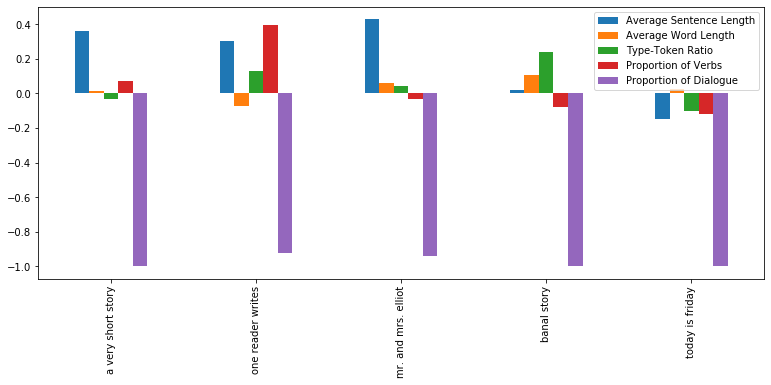

In [74]:
normalizedStoryStyleDf.T[largestIndexes].T.plot(kind='bar',figsize = (13,5))
normalizedStoryStyleDf.T[largestIndexes].T

Right away, from this dataset, one important observation can be made: Although there are some relatively high stylistic deviations in several of the characteristics - "Mr. and Mrs. Elliot", for example, has sentences which are more than 40% longer than those in the model texts of the corpus, and "One Reader Writes" has a proportion of verbs which is 40% higher - each of the texts has its most substantial difference in its proportion of dialogue. These differences are all markedly similar: all of them have substantially less dialogue than the average, and three of them have no dialogue at all (which is what is represented by a -100% relative style difference). This trend continues for the following five most distinctive stories, all of which have a very low level of measured proportion of dialogue. At first blush, therefore, it would seem that a fair conclusion could be that the proportion of dialogue alone is a sufficient stylistic marker for identifying a Hemingway story.

However, a closer look at the stories reveals other important shared characteristics. As might be assumed by the title, "A Very Short Story" is, in fact, very brief - it is only 863 words, and is the fifth shortest story in the collection of 69. Among those stories shorter than it are "Banal Story", which numbers 743 words and is the third shortest, and "One Reader Writes", which contains only 566 words and is the shortest story in the collection. Of these three concise tales, "A Very Short Story" and "Banal story" are very close in their form: Both are short and narrated in the third person by semi-omniscient narrators who exhibit a very low level of narrative distance, and frequently report on the thoughts of the characters. They differ importantly in their scope, "A Very Short Story" spanning several short episodes and containing multiple named characters, while "Banal Story" covers only a single, short moment in its solitary unnamed protagonists life. The lack of dialogue in these stories appears to be due to the constraint of their length, given that expository narration is a much more efficient way of conveying information than indirectly through dialogue. These stories are unique amongst Hemingway stories because they are unusually brief, and with that brevity comes the necessary stylistic constraint of reducing dialogue.

In contrast, although it is similarly short, "One Reader Writes" is structurally quite different; it is largely comprised of a letter, written by a distressed woman to a doctor about the health of her husband (who has been infected with "sifilus" while away at war), and is concluded by a paragraph-long stream-of-consciousness monologue by the same woman. Although it is technically told from a removed, third person narrative perspective, this closing paragraph, which contains nearly a third of the text, combined with the contents of the letter, which is nearly half of the text, effectively render it a first-person narrative. This, along with the fact that the protagonist is a woman, makes it a tremendously uncharacteristic story for Hemingway. The lack of dialogue here seems to be not structural but thematic, as it is an extraordinarily internal story which essentially deals with one woman's single thought, and the higher proportion of verbs noted earlier may reflect the voice of the protagonist as it is present in both the letter and the monologue. 

The remaining stories, "Mr. and Mrs. Elliot" and "Today is Friday", do not share in the extraordinary brevity of the other stories (Although they are also quite short, being only 1,658 and 1,468 tokens in length, respectively, they are 2-3 times lengthier than their counterparts). In its form, "Mr. and Mrs. Elliot" bears a basic similarity to "A Very Short Story" - it plots a distressed love story, through several brief scenes, narrated by a semi-omniscient 3rd person voice, and contains very very little dialogue. In this story too it seems as though the lack of dialogue is a consequence of the scope of the plot and the constraints of its length. "Today is Friday", however, is an utterly unique, very experimental story, both in form and content. It is formatted in the style of a play script, and is therefore ostensibly told entirely through dialogue, although not in a fashion which can be found in any other story in this collection. It is set in ancient Rome, on the day of the crucifiction of Jesus Christ, and its central characters are three Roman soldiers and a Jewish wine merchant. This temporal displacement is very unusual for Hemingway, who most often wrote in the relative present, and further solidifies the strangeness of the story. The characters, setting, structure, and style of "Today is Friday" are not to be found in any other Hemingway story, and it is therefore an extraordinarily unusual and uncharacteristic piece of writing.

Selecting stories for their stylistic distance therefore appears to have done two things: first, sorted for stories which are conventional in their content and structure, but stylistically distinctive because they are very short and consquently have very little dialogue, such as "A Very Short Story", "Banal Story", and "Mr. and Mrs. Elliot"; and second, sorted for genuinely unique and uncharacteristic stories, like "One Reader Writes"- which contains the only excerpted letter in any of the stories, and "Today is Friday"- which is unique in nearly every way.

##  Part Three: Identifying and Analyzing Chunks of Text which Break the Style 

Although generating interesting results, the sort of selection I performed in Part Two is limited in that it effectively found the most distinctive Hemingway stories, which  says little about what it means for a raw piece of text to be stylistically distinctive. Sorting by story allows for the conclusions to be confounded by factors like story length and structure, which would not translate to a passage in a novel. In order to avoid this confounding, I performed the same style of analysis on smaller, equally sized chunks of the test text, each 1,000 tokens long. The relative style difference of the five most distinctive chunks of text are as follows (unfortunately the chunk indexes are not very informative ):

,Average Sentence Length,Average Word Length,Type-Token Ratio,Proportion of Verbs,Proportion of Dialogue
160000,1.943819,0.161859,0.173787,-0.057039,-0.898886
15000,1.586993,0.128095,0.066877,-0.242407,-1.000000
161000,1.586993,0.105826,0.142605,0.055794,-1.000000
130000,1.510905,0.012374,0.002285,0.128330,-1.000000
94000,1.510905,0.031779,-0.041147,-0.113455,-0.741268


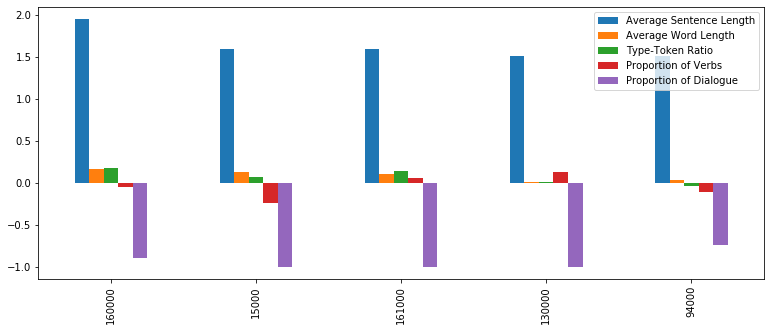

In [72]:
mostDistinctiveChunkStyleDifferences.plot(kind='bar',figsize = (13,5))
mostDistinctiveChunkStyleDifferences

The chunks correspond to the following stories:
- "A Natural History of the Dead", chunks 160,000-161,000 and 161,000-162,000
- "The Capital of the world", chunk 15,000-16,000
- "Now I Lay Me", chunk 130,000-131,000
- "In Another Country", chunk 94,000-95,000

Once again, this data shows some very interesting features right away. As with the stories, each of these excerpts have an uncharacteristically low proportion of dialogue, with the excerpts from "The Capital of the World", "A Natural History of the Dead", and "Now I lay Me" having no dialogue at all. Additionally, however, these excerpts all share another exaggerated feature: they all have an average sentence length which is at least 150% greater than that of the model corpus. These characteristics in tandem describe a type of text which is long-winded, descriptive, and low on grounded inter-character interactions. It is also notable that none of these excerpts come from the set of most distinctive stories- which indicates that although the stories themselves may be relatively conventional, they still contain extraordinary and unusual passages.

Beyond their quantified characteristics, these stories do share several qualities. They are structurally similar in that they are split into a lengthy, expository first section which features little to no dialogue, and a dialogue and action intensive second section, which contains whatever plot there might be (in each of these stories it was an excerpt from the expository first section which was labeled stylistically distinctive). "A Natural History of the Dead", "Now I lay Me", and "In Another Country" are all war stories which focus on injury, and the latter pair are both set in hospitals and deal with the nature of recovery and loss. "The Capital of the World" shares the motif of injury and death, while exchanging the war backdrop for amateur bullfighting in Madrid. The flagged excerpts from "In Another Country" and "The Capital of the World" are largely made up of third person, semi-omniscient exposition. They are concerned with establishing the setting and important characters, but are unusually protracted and illustrative in doing so. These two stories are relatively conventional, and the flagged passages from them are stylistically distinct and unusual in Hemingway's work. The other two stories, however, are more substantially distinctive, and their marked passages are unique in more obvious ways. 

The marked passage from "Now I Lay Me" is an excerpt of a long, first person monologue from the perspective of a wounded soldier afflicted with insomnia. It details his dreamlike fantasy of fishing in every trout stream he has ever seen, and in some genuinely beautiful, evocative illustration it conveys the extent of his delirium. This may, in part, explain its extraordinary sentence length- the first person perspective meaning the stylistic characteristics of the protagonist are those which are being measured, as opposed to the usual removed narrator, and the protagonists exhaustion might explain the rambling nature of the sentences. For example, the following sentence, which describes the central characters reasons for being unable to sleep, is nearly four times the length of the average sentence in the model texts: 
> "I myself did not want to sleep because I had been living for a long time with the knowledge that if I ever shut my eyes in the dark and let myself go, my soul would go out of my body" (The Complete Stories, 276)

The rest of the story contains a lengthy vignette of a story from the narrator's childhood, and a strangely idle conversation between the narrator and another sleepless soldier about marriage. 

It is notable that two of the most distinctive passages in Hemingway's complete short stories are from the same piece, and "A Natural History of the Dead" does indeed prove to be very unusual. It is really only loosely a story- it features a very short dialogue exchange in its final two pages which bear a small resemblance to a Hemingway tale (an angry exchange between a group of soldiers and a war-doctor about whether an injured lieutenant should be put out of his misery or left to die)- but otherwise contains no plot, continuous narrative, or characters to speak of. It is uncharacteristically written in the first person, which suits well it's rambling, opinionated description of the characteristics of the dead on a battlefield. The excerpted portions are both taken from this rambling section, and contain, along with the war imagery: musings about the life and experiences of 17th century explorer and naturalist Mungo Park, and a tirade against literary thinkers of the "humanist" school, who are described as "sterile" and overly "decorus" (The Complete Stories, 338). It is a strange story because it is hardly a story at all, and the passages which are the most distinctive read nearly like an meandering essay, experimental and unusual. 

## Conclusion

Ernest Hemingway's stylistic influence is far reaching and powerful, and the distinctiveness of his style is inarguable. His writing can, by measuring certain qualities which are characteristic of him, be identified with a high degree of success, and can easily be distinguished from the writing of others. However, there are stories and passages of Hemingway which break his stylistic convention, and are unusual in doing so. In his stories, it is usually the shortest, least dialogue-heavy which are the most stylistically distinctive, although there are some very experimental stories which are distinctive for other, more varied reasons. However, focusing on his stories is not an ideal method of establishing what characterizes distinctive writing for Hemingway, because the format adds certain confounding factors like length and structure. In his writing in general, it is the passages which are expository and descriptive, low on dialogue and high on illustration which deviate from his style to the highest degree. It is worth noting that large stylistic variation is really quite unusual for Hemingway, and that more often than not he is recognizably, inarguably, and definitely Himself.

## Works Cited
Hemingway, Ernest. A Farewell to Arms. Charles Scribner's Sons, 1993. 

Hemingway, Ernest. For Whom the Bell Tolls. Scribner, 2019. 

Hemingway, Ernest. The Complete Short Stories of Ernest Hemingway. Scribner, 1987. 

Hemingway, Ernest. The Sun Also Rises. Scribner, 2016. 

Hemingway, Ernest. Three Novels of Ernest Hemingway. C. Scribner., 1962.   

Levin, Harry. “Observations on the Style of Ernest Hemingway.” The Kenyon Review, vol. 13, no. 4, 1951, pp. 581–609. 

O'Hara, John. “The Author's Name Is Hemingway.” The New York Times, 10 Sept. 1950. 

##### Note:
After having found the most distinctive Hemingway story according to my model, I realized that it was possible to do the opposite: to find the story which is the closest match to Hemingway's style and therefore the "most Hemingway", so I did! The story is "The Doctor and the Doctor's Wife" which is hosted here by the University of Virginia:
http://xroads.virginia.edu/~Hyper/HEMXXINGXxWAY/ch02.html